In [1]:
#import definitions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

In [2]:
#read in data
wego = pd.read_csv("../data/Headway Data, 8-1-2023 to 9-30-2023.csv")

In [3]:
#define rgb colors for charts
purple = 0.459, 0.235, 0.745
gray = 0.827, 0.827, 0.827
black = 0.137, 0.122, 0.125

In [4]:
##various explores
#preview data
#wego.head()
#wego.info(verbose=True)

#### Cleaning & Derived Columns:

In [5]:
#drop rows with missing arrival or departure times
wego = wego.loc[(wego['ADJUSTED_ONTIME_COUNT'] == 1)
        |
        (wego['ADJUSTED_EARLY_COUNT'] == 1)
        |
        (wego['ADJUSTED_LATE_COUNT'] == 1)]

In [6]:
# Calculate HDWY Deviation Percentage
def get_dev_pct(row):
    '''Takes a row as input, returns a perfencate value. 
    Calculate the headway deviation percentage taking into
    consideration the possibility of SCHEDULED_HDWY being 0'''
    if row['SCHEDULED_HDWY'] != 0:
        return (row['HDWY_DEV']) / row['SCHEDULED_HDWY'] * 100
    else:
        return np.NaN

# create headway deviation percentage column
wego['HDWY_DEV_PCT'] = wego.apply(lambda r: get_dev_pct(r), axis=1)

In [7]:
#establish columns for gapping, bunching, and acceptable headway values
wego['HDWY_GAPPING'] = 0
wego['HDWY_ACCEPTABLE'] = 0
wego['HDWY_BUNCHING'] = 0

In [8]:
#establish functions for populating headway columns
#Note that you can calculate headway deviation percentage as HDWY_DEV/SCHEDULED_HDWY. 
#The generally accepted range of headway deviation is 50% to 150% of the scheduled headway 
#so if scheduled headway is 10 minutes, a headway deviation of up to 5 minutes would be acceptable (but not ideal).

def hdw_gapping(pct):
    if (pct > 0) & (abs(pct) > 50):
        return int(1)
    else:
        return int(0)
    
def hdw_acceptable(pct):
    if abs(pct) <= 50:
        return int(1)
    else:
        return int(0)
    
def hdw_bunching(pct):
    if (pct < 0) & (abs(pct) > 50):
        return int(1)
    else:
        return int(0)

In [9]:
#execute functions and apply 0/1 values to columns
wego['HDWY_BUNCHING'] = wego['HDWY_DEV_PCT'].apply(hdw_bunching)
wego['HDWY_ACCEPTABLE'] = wego['HDWY_DEV_PCT'].apply(hdw_acceptable)
wego['HDWY_GAPPING'] = wego['HDWY_DEV_PCT'].apply(hdw_gapping)

In [10]:
# #inspect new columns
#print(wego.HDWY_GAPPING.sum())
#print(wego.HDWY_ACCEPTABLE.sum())
#print(wego.HDWY_BUNCHING.sum())

In [11]:
#create a unique identifier
wego['DATE_TRIP'] = wego.apply(lambda row: str(row['CALENDAR_ID']) + '-' + str(row['TRIP_ID']), axis=1)

In [12]:
print('Number of distinct trips: ' + str(wego.DATE_TRIP.nunique()))

Number of distinct trips: 66450


#### About our data

In [13]:
wego.columns

Index(['CALENDAR_ID', 'SERVICE_ABBR', 'ADHERENCE_ID', 'DATE', 'ROUTE_ABBR',
       'BLOCK_ABBR', 'OPERATOR', 'TRIP_ID', 'OVERLOAD_ID',
       'ROUTE_DIRECTION_NAME', 'TIME_POINT_ABBR', 'ROUTE_STOP_SEQUENCE',
       'TRIP_EDGE', 'LATITUDE', 'LONGITUDE', 'SCHEDULED_TIME',
       'ACTUAL_ARRIVAL_TIME', 'ACTUAL_DEPARTURE_TIME', 'ADHERENCE',
       'SCHEDULED_HDWY', 'ACTUAL_HDWY', 'HDWY_DEV', 'ADJUSTED_EARLY_COUNT',
       'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT', 'STOP_CANCELLED',
       'PREV_SCHED_STOP_CANCELLED', 'IS_RELIEF', 'DWELL_IN_MINS',
       'SCHEDULED_LAYOVER_MINUTES', 'HDWY_DEV_PCT', 'HDWY_GAPPING',
       'HDWY_ACCEPTABLE', 'HDWY_BUNCHING', 'DATE_TRIP'],
      dtype='object')

In [14]:
# date range start
wego.DATE.min()

'8/1/2023'

In [15]:
#date range end
wego.DATE.max()

'9/9/2023'

In [16]:
#number of routes
wego.ROUTE_ABBR.nunique()

8

In [17]:
#number of trips
wego.DATE_TRIP.nunique()

66450

In [18]:
#number of drivers
wego.OPERATOR.nunique()

341

In [19]:
#number of stops
len(wego)

338861

#### 1. What is the overall on-time performance, and what do the overall distributions of adherence and headway deviation look like? 

In [20]:
#overall on time performance
round(wego.ADJUSTED_ONTIME_COUNT.sum()/len(wego.ADJUSTED_ONTIME_COUNT)*100,2)

79.69

79.69% of trips are on time.

In [21]:
wego.ADJUSTED_EARLY_COUNT.sum() + wego.ADJUSTED_LATE_COUNT.sum() + wego.ADJUSTED_ONTIME_COUNT.sum()

338861

AttributeError: 'Axes' object has no attribute 'show'

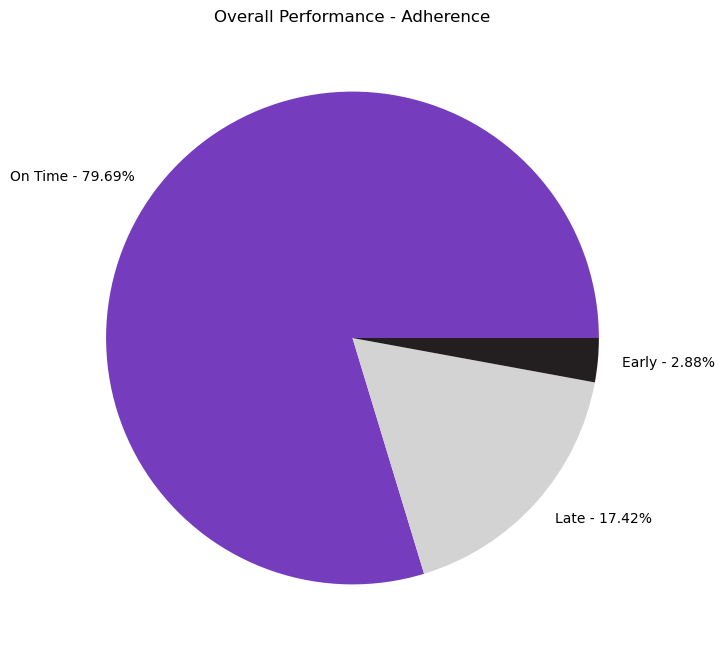

In [22]:
# Adherence graph - pie
# autopct='%1.2f%%'
pchart = wego[['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']].sum().plot(kind='pie', colors=(purple, gray, black), labels=['On Time - 79.69%', 'Late - 17.42%', 'Early - 2.88%'], labeldistance=1.10, figsize=(10,8))
pchart.set (title = 'Overall Performance - Adherence')
plt.savefig('../images/overall_performance_pie.png')
pchart.show()

In [23]:
#perfect_trips
perfect_trips = wego.groupby('DATE_TRIP')[['ADJUSTED_EARLY_COUNT',
       'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT']].sum()
perfect_trips = perfect_trips[(perfect_trips.ADJUSTED_EARLY_COUNT == 0) & (perfect_trips.ADJUSTED_LATE_COUNT == 0)]

perfect_count = len(perfect_trips)

percent_perfect = perfect_count/(wego.DATE_TRIP.nunique())*100

print('Number of perfect trips: ' + str(perfect_count))
print('Percentage of perfect trips: ' + str(percent_perfect))


Number of perfect trips: 39923
Percentage of perfect trips: 60.07975921745673


In [ ]:
## Per Dibran - use adjusted fields and newly calculated hdwy to chart performance
#distribution of headway and adherence
ad_stddev = np.std(wego.ADHERENCE)
ad_mean = wego.ADHERENCE.mean()
ad_min = ad_mean-(ad_stddev*3)
ad_max = ad_mean+(ad_stddev*3)

hdw_stddev = np.std(wego.HDWY_DEV)
hdw_mean = wego.HDWY_DEV.mean()
hdw_min = hdw_mean-(hdw_stddev*3)
hdw_max = hdw_mean+(hdw_stddev*3)

In [ ]:
# wego.ADHERENCE.describe()

In [ ]:
# #distributions of adherence
# adherence_cats = wego[wego['ADJUSTED_EARLY_COUNT','ADJUSTED_ONTIME_COUNT','ADJUSTED_LATE_COUNT']].sum()
# # adherence_cats.plot(kind='hist')
# # adherence_cats.set(title='Adherence Distribution by Category', xlabel='Category',  ylabel='Count of Stops')
# sns.histplot(data=adherence_cats)

In [ ]:
total_adh_count = len(wego.ADHERENCE)
adh_non_outlier = len(wego[wego['ADHERENCE'].between(ad_min, ad_max, inclusive='both')])
adh_outlier_count = total_adh_count - adh_non_outlier
print(adh_outlier_count)

total_hdw_count = len(wego.HDWY_DEV)
hdw_non_outlier = len(wego[wego['HDWY_DEV'].between(hdw_min, hdw_max, inclusive='both')])
hdw_outlier_count = total_hdw_count - hdw_non_outlier
print(hdw_outlier_count)



In [ ]:
#distributions of adherence deviation
adherence_hist = wego[wego['ADHERENCE'].between(ad_min, ad_max, inclusive='both')]['ADHERENCE'].plot(kind='hist', bins=50, color = purple)
adherence_hist.set(title='Adherence Distribution Excluding Outliers', xlabel='Adherence',  ylabel='Count of Stops')
#plt.savefig('../images/ahderence_distribution.png')
adherence_hist.show()

In [ ]:
wego.HDWY_DEV.describe()

In [ ]:
#distributions of headway deviation
adherence_hist = wego[wego['HDWY_DEV'].between(hdw_min, hdw_max, inclusive='both')]['HDWY_DEV'].plot(kind='hist', bins=50, color = purple)
adherence_hist.set(title='Headway Distribution Excluding Outliers', xlabel='Headway in Minutes',  ylabel='Count of Stops')
plt.savefig('../images/headway_distribution.png')
plt.show()

### 2. How does direction of travel, route, or location affect the headway and on-time performance?

#### Q2 Findings:
-- Buses headed into downtown are more timely than outbound buses </br>
-- Route 22 is the most timely </br>
-- 

In [ ]:
wego.columns

#### Direction

In [ ]:
#ADHERENCE
routes_totals = (
    wego.groupby('ROUTE_DIRECTION_NAME')
         [['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']]
         .sum()
)

routes_totals['TOTALS'] = routes_totals.sum(axis=1)

routes_totals['ONTIME_PCT'] = routes_totals['ADJUSTED_ONTIME_COUNT'] / routes_totals['TOTALS'] * 100
routes_totals['EARLY_PCT'] = routes_totals['ADJUSTED_EARLY_COUNT'] / routes_totals['TOTALS'] * 100
routes_totals['LATE_PCT'] = routes_totals['ADJUSTED_LATE_COUNT'] / routes_totals['TOTALS'] * 100

# Route Adherence graph
ax = (
    routes_totals[['ONTIME_PCT', 'EARLY_PCT', 'LATE_PCT']]
).sort_values('ONTIME_PCT', ascending=False).plot(kind='bar', stacked=True, color = (purple, gray, black))
ax.set(title = 'Route Direction Adherence Performance',
        xlabel = 'Route Direction',
       ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1))
ax.tick_params(axis='x', rotation=0)
#plt.savefig('../images/route_adherence.png')
plt.show()

In [ ]:
routes_totals.head()

In [ ]:
# #initial adherence by direction using count of stops
# #headyway and adherence by route direction
# ad_chart = wego.groupby('ROUTE_DIRECTION_NAME')[['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']].sum().plot(kind='bar', stacked=True)
# ad_chart.set(title='Route Direction Adherence by Category', xlabel = 'Direction', ylabel = 'Count of Stops')
# ad_chart.legend(bbox_to_anchor=(1, 1))

In [ ]:
#HEADWAY
routes_totals = (
    wego.groupby('ROUTE_DIRECTION_NAME')
         [['HDWY_ACCEPTABLE','HDWY_BUNCHING','HDWY_GAPPING']]
         .sum()
)

routes_totals['TOTALS'] = routes_totals.sum(axis=1)

routes_totals['ACCEPTABLE_PCT'] = routes_totals['HDWY_ACCEPTABLE'] / routes_totals['TOTALS'] * 100
routes_totals['BUNCHING_PCT'] = routes_totals['HDWY_BUNCHING'] / routes_totals['TOTALS'] * 100
routes_totals['GAPING_PCT'] = routes_totals['HDWY_GAPPING'] / routes_totals['TOTALS'] * 100

# Route Adherence graph
ax = (
    routes_totals[['ACCEPTABLE_PCT', 'BUNCHING_PCT', 'GAPING_PCT']]
).sort_values('ACCEPTABLE_PCT', ascending=False).plot(kind='bar', stacked=True, color = (purple, gray, black))
ax.set(title = 'Route Direction Headway Performance',
        xlabel = 'Route Direction',
       ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1), labels = ['Acceptable', 'Bunching', 'Gapping'])
ax.tick_params(axis='x', rotation=0)
#plt.savefig('../images/route_headway.png')
plt.show()

In [ ]:
# #initial headway by route direction using count of stops
# hdw_chart = wego.groupby('ROUTE_DIRECTION_NAME')[['HDWY_ACCEPTABLE','HDWY_BUNCHING','HDWY_GAPPING']].sum().plot(kind='bar', stacked=True)
# hdw_chart.set(title='Route Direction Headway by Category', xlabel = 'Direction', ylabel = 'Count of Stops')
# hdw_chart.legend(bbox_to_anchor=(1, 1))


In [ ]:
wego.groupby('ROUTE_DIRECTION_NAME')[['ADHERENCE','HDWY_DEV']].mean()

#### Route

In [ ]:
#break down stops by percentage of category
routes_totals = (
    wego.groupby('ROUTE_ABBR')
         [['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']]
         .sum()
)

routes_totals['TOTALS'] = routes_totals.sum(axis=1)

routes_totals['ONTIME_PCT'] = routes_totals['ADJUSTED_ONTIME_COUNT'] / routes_totals['TOTALS'] * 100
routes_totals['EARLY_PCT'] = routes_totals['ADJUSTED_EARLY_COUNT'] / routes_totals['TOTALS'] * 100
routes_totals['LATE_PCT'] = routes_totals['ADJUSTED_LATE_COUNT'] / routes_totals['TOTALS'] * 100

# Route Adherence graph
ax = (
    routes_totals[['ONTIME_PCT', 'EARLY_PCT', 'LATE_PCT']]
).sort_values('ONTIME_PCT', ascending=False).plot(kind='bar', stacked=True, color = (purple, gray, black))
ax.set(title = 'Route Adherence Performance',
        xlabel = 'Route',
       ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1))
ax.tick_params(axis='x', rotation=0)
#plt.savefig('../images/routeID_adherence.png')
plt.show()

In [ ]:
# #initial adherence by route ID using count of stops
# #aherence by route ID
# rte_adh_chart = wego.groupby('ROUTE_ABBR')[['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']].sum().sort_values('ADJUSTED_ONTIME_COUNT', ascending=False).plot(kind='bar', stacked=True)
# rte_adh_chart.set(title='Adherence by Route', xlabel = 'Route Abbreviation', ylabel = 'Count of Stops')
# rte_adh_chart.legend(bbox_to_anchor=(1, 1))

In [ ]:
#break down stops by percentage of category - headway
routes_totals = (
    wego.groupby('ROUTE_ABBR')
         [['HDWY_ACCEPTABLE','HDWY_BUNCHING','HDWY_GAPPING']]
         .sum()
)

routes_totals['TOTALS'] = routes_totals.sum(axis=1)

routes_totals['ACCEPTABLE_PCT'] = routes_totals['HDWY_ACCEPTABLE'] / routes_totals['TOTALS'] * 100
routes_totals['BUNCHING_PCT'] = routes_totals['HDWY_BUNCHING'] / routes_totals['TOTALS'] * 100
routes_totals['GAPPING_PCT'] = routes_totals['HDWY_GAPPING'] / routes_totals['TOTALS'] * 100

# Route Adherence graph
ax = (
    routes_totals[['ACCEPTABLE_PCT', 'BUNCHING_PCT', 'GAPPING_PCT']]
).sort_values('ACCEPTABLE_PCT', ascending=False).plot(kind='bar', stacked=True, color = (purple, gray, black))
ax.set(title = 'Route Headway Performance',
        xlabel = 'Route',
       ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1))
ax.tick_params(axis='x', rotation=0)
#plt.savefig('../images/routeID_headway.png')
plt.show()

In [ ]:
#intitial headway by route ID using count of stops
# #headway by route ID
# rte_hdw_chart = wego.groupby('ROUTE_ABBR')[['HDWY_ACCEPTABLE','HDWY_BUNCHING','HDWY_GAPPING']].sum().sort_values('HDWY_ACCEPTABLE', ascending=False).plot(kind='bar', stacked=True)
# rte_hdw_chart.set(title='Headway by Route', xlabel = 'Route Abbreviation', ylabel = 'Count of Stops')
# rte_hdw_chart.legend(bbox_to_anchor=(1, 1))

In [ ]:
wego.groupby('ROUTE_ABBR')[['ADHERENCE','HDWY_DEV']].mean()

#### Stop location

In [ ]:
wego.groupby('TIME_POINT_ABBR')[['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']].sum().sort_values('ADJUSTED_ONTIME_COUNT', ascending=False)

In [ ]:
#break down stops by percentage of category
location_totals = (
    wego.groupby('TIME_POINT_ABBR')
         [['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']]
         .sum()
)

location_totals['TOTALS'] = location_totals.sum(axis=1)

location_totals['ONTIME_PCT'] = location_totals['ADJUSTED_ONTIME_COUNT'] / location_totals['TOTALS'] * 100
location_totals['EARLY_PCT'] = location_totals['ADJUSTED_EARLY_COUNT'] / location_totals['TOTALS'] * 100
location_totals['LATE_PCT'] = location_totals['ADJUSTED_LATE_COUNT'] / location_totals['TOTALS'] * 100

# Route Adherence graph
ax = (
    location_totals[['ONTIME_PCT', 'EARLY_PCT', 'LATE_PCT']]
).sort_values('ONTIME_PCT', ascending=False).plot(kind='bar', stacked=True, figsize=(13,8), color = (purple, gray, black))
ax.set(title = 'Stop Location Adherence Performance',
        xlabel = 'Stop ID',
       ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1))
ax.tick_params(axis='x', rotation=90)
#plt.savefig('../images/stopID_adherence.png')
plt.show()

In [ ]:
# initial analysis - not adjusted for percentage
# #adherence by stop location
# #loc_adh_chart.figure(figsize=(12,12))
# loc_adh_chart = wego.groupby('TIME_POINT_ABBR')[['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']].sum().sort_values('ADJUSTED_ONTIME_COUNT', ascending=False).plot(kind='bar', stacked=True, width=0.6, figsize=(13,8))
# loc_adh_chart.set(title='Adherence by Stop Location', xlabel = 'Stop ID', ylabel = 'Count of Stops')
# loc_adh_chart.legend(bbox_to_anchor=(1, 1))

In [ ]:
#break down stops by percentage of category - headway
location_totals = (
    wego.groupby('TIME_POINT_ABBR')
         [['HDWY_ACCEPTABLE','HDWY_BUNCHING','HDWY_GAPPING']]
         .sum()
)

location_totals['TOTALS'] = location_totals.sum(axis=1)

location_totals['ACCEPTABLE_PCT'] = location_totals['HDWY_ACCEPTABLE'] / location_totals['TOTALS'] * 100
location_totals['BUNCHING_PCT'] = location_totals['HDWY_BUNCHING'] / location_totals['TOTALS'] * 100
location_totals['GAPPING_PCT'] = location_totals['HDWY_GAPPING'] / location_totals['TOTALS'] * 100

# Stop ID Adherence graph
ax = (
    location_totals[['ACCEPTABLE_PCT', 'BUNCHING_PCT', 'GAPPING_PCT']]
).sort_values('ACCEPTABLE_PCT', ascending=False).plot(kind='bar', stacked=True, figsize=(13,8), color = (purple, gray, black))
ax.set(title = 'Stop Location Headway Performance',
        xlabel = 'Stop ID',
       ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1))
ax.tick_params(axis='x', rotation=90)
#plt.savefig('../images/stopID_headway.png')
plt.show()

In [ ]:
# initial analysis - not adjusted for percentage
# #headway by stop location
# loc_hdw_chart = wego.groupby('TIME_POINT_ABBR')[['HDWY_ACCEPTABLE','HDWY_BUNCHING','HDWY_GAPPING']].sum().sort_values('HDWY_ACCEPTABLE', ascending=False).plot(kind='bar', stacked=True, width=0.6, figsize=(13,8))
# loc_hdw_chart.set(title='Headway by Stop Location', xlabel = 'Stop ID', ylabel = 'Count of Stops')
# # loc_hdw_chart.legend(bbox_to_anchor=(1, 1))

In [ ]:
wego.groupby('TIME_POINT_ABBR')[['ADHERENCE','HDWY_DEV']].mean().sort_values('ADHERENCE', ascending=True)

### 3. How does time of day or day of week affect headway and on-time performance?

#### Time of Day

In [ ]:
wego.info(verbose=True, show_counts=True)

In [ ]:
#drop rows where there's no actual departure time values
clean_dept_time = wego.dropna(subset=['ACTUAL_DEPARTURE_TIME'])

In [ ]:
# Create depart time column
clean_dept_time['HOUR'] = (pd.to_datetime(clean_dept_time['ACTUAL_DEPARTURE_TIME'],
                                          format='mixed').dt.hour)

In [ ]:
hour_totals = (
    clean_dept_time.groupby('HOUR')
         [['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']]
         .sum())
hour_totals

In [ ]:
#ADHERENCE
hour_totals = (
    clean_dept_time.groupby('HOUR')
         [['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']]
         .sum()
)

hour_totals['TOTALS'] = hour_totals.sum(axis=1)

hour_totals['ONTIME_PCT'] = hour_totals['ADJUSTED_ONTIME_COUNT'] / hour_totals['TOTALS'] * 100
hour_totals['EARLY_PCT'] = hour_totals['ADJUSTED_EARLY_COUNT'] / hour_totals['TOTALS'] * 100
hour_totals['LATE_PCT'] = hour_totals['ADJUSTED_LATE_COUNT'] / hour_totals['TOTALS'] * 100

# Route Adherence graph
ax = (
    hour_totals[['ONTIME_PCT', 'EARLY_PCT', 'LATE_PCT']]
).sort_values('HOUR', ascending=True).plot(kind='bar', stacked=True, color = (purple, gray, black))
ax.set(title = 'Hourly Adherence Performance',
        xlabel = 'Hour',
       ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1))
ax.tick_params(axis='x', rotation=0)
plt.savefig('../images/hourly_adherence.png')
plt.show()

In [ ]:
hour_totals = (
    clean_dept_time.groupby('HOUR')
         [['HDWY_ACCEPTABLE','HDWY_BUNCHING','HDWY_GAPPING']]
         .sum()
)

hour_totals['TOTALS'] = hour_totals.sum(axis=1)

hour_totals['ACCEPTABLE_PCT'] = hour_totals['HDWY_ACCEPTABLE'] / hour_totals['TOTALS'] * 100
hour_totals['BUNCHING_PCT'] = hour_totals['HDWY_BUNCHING'] / hour_totals['TOTALS'] * 100
hour_totals['GAPPING_PCT'] = hour_totals['HDWY_GAPPING'] / hour_totals['TOTALS'] * 100

# Hour Headway graph
ax = (
    hour_totals[['ACCEPTABLE_PCT', 'BUNCHING_PCT', 'GAPPING_PCT']]
).sort_values('HOUR', ascending=True).plot(kind='bar', stacked=True, color = (purple, gray, black))
ax.set(title = 'Hourly Headway Performance',
        xlabel = 'Hour',
       ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1))
ax.tick_params(axis='x', rotation=0)
#plt.savefig('../images/hourly_headway.png')
plt.show()

#### By day of week

In [ ]:
clean_dept_time['WEEKDAY'] = pd.to_datetime(clean_dept_time['ACTUAL_DEPARTURE_TIME']).dt.weekday

In [ ]:
#ADHERENCE
day_totals = (
    clean_dept_time.groupby('WEEKDAY')
         [['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']]
         .sum()
)

day_totals['TOTALS'] = day_totals.sum(axis=1)

day_totals['ONTIME_PCT'] = day_totals['ADJUSTED_ONTIME_COUNT'] / day_totals['TOTALS'] * 100
day_totals['EARLY_PCT'] = day_totals['ADJUSTED_EARLY_COUNT'] / day_totals['TOTALS'] * 100
day_totals['LATE_PCT'] = day_totals['ADJUSTED_LATE_COUNT'] / day_totals['TOTALS'] * 100

# Route Adherence graph
ax = (
    day_totals[['ONTIME_PCT', 'EARLY_PCT', 'LATE_PCT']]
).sort_values('WEEKDAY', ascending=True).plot(kind='bar', stacked=True, color = (purple, gray, black))
ax.set(title = 'Adherence Performance by Day of Week',
        xlabel = 'Day',
       ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1))
ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.tick_params(axis='x', rotation=45)
plt.savefig('../images/dayofweek_adherence.png')
plt.show()

In [ ]:
#HEADWAY
day_totals = (
    clean_dept_time.groupby('WEEKDAY')
         [['HDWY_ACCEPTABLE','HDWY_BUNCHING','HDWY_GAPPING']]
         .sum()
)

day_totals['TOTALS'] = day_totals.sum(axis=1)

day_totals['ACCEPTABLE_PCT'] = day_totals['HDWY_ACCEPTABLE'] / day_totals['TOTALS'] * 100
day_totals['BUNCHING_PCT'] = day_totals['HDWY_BUNCHING'] / day_totals['TOTALS'] * 100
day_totals['GAPPING_PCT'] = day_totals['HDWY_GAPPING'] / day_totals['TOTALS'] * 100

# Hour Headway graph
ax = (
    day_totals[['ACCEPTABLE_PCT', 'BUNCHING_PCT', 'GAPPING_PCT']]
).sort_values('WEEKDAY', ascending=True).plot(kind='bar', stacked=True, color = (purple, gray, black))
ax.set(title = 'Headway Performance by Day of Week',
        xlabel = 'Day',
       ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1))
ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.tick_params(axis='x', rotation=45)
plt.savefig('../images/dayofweek_headway.png')
plt.show()

In [ ]:
# grouper dt conversion to redo hourly groupings
# clean_dept_time['ACTUAL_DEPARTURE_TIME'] = pd.to_datetime(clean_dept_time['ACTUAL_DEPARTURE_TIME'])

##### 4. How much of a factor does the driver have on headway and on-time performance? The driver is indicated by the OPERATOR variable.

#### number 4 - group by operator, what percent of stops are acceptable vs total stops

#### drivers along individual routes

In [ ]:
#### number 4 - group by operator, what percent of stops are acceptable vs total stops

In [ ]:
# wego.OPERATOR.nunique()

In [ ]:
wego.groupby('OPERATOR')[['HDWY_ACCEPTABLE','HDWY_BUNCHING','HDWY_GAPPING','ADJUSTED_EARLY_COUNT','ADJUSTED_LATE_COUNT','ADJUSTED_ONTIME_COUNT']].sum()

In [ ]:
wego.head()

In [ ]:
#HEADWAY
operator_totals = (
    wego.groupby('OPERATOR')
         [['HDWY_ACCEPTABLE','HDWY_BUNCHING','HDWY_GAPPING','ADJUSTED_EARLY_COUNT','ADJUSTED_LATE_COUNT','ADJUSTED_ONTIME_COUNT']]
         .sum()
)

operator_totals['ADHERENCE_TOTALS'] = operator_totals[['ADJUSTED_EARLY_COUNT','ADJUSTED_LATE_COUNT','ADJUSTED_ONTIME_COUNT']].sum(axis=1)
operator_totals['HEADWAY_TOTALS'] = operator_totals[['HDWY_ACCEPTABLE','HDWY_BUNCHING','HDWY_GAPPING']].sum(axis=1)

operator_totals['ACCEPTABLE_ADHERENCE_PCT'] = operator_totals['ADJUSTED_ONTIME_COUNT'] / operator_totals['ADHERENCE_TOTALS'] * 100
operator_totals['ACCEPTABLE_HEADWAY_PCT'] = operator_totals['HDWY_ACCEPTABLE'] / operator_totals['HEADWAY_TOTALS'] * 100



In [ ]:
op_summary = operator_totals[['ADHERENCE_TOTALS', 'ACCEPTABLE_ADHERENCE_PCT', 'HEADWAY_TOTALS', 'ACCEPTABLE_HEADWAY_PCT']].sort_values('ACCEPTABLE_ADHERENCE_PCT', ascending=False)
op_summary

In [ ]:
top20_adh = (op_summary[op_summary['ADHERENCE_TOTALS'] >= 1000]
            .nlargest(20, columns=['ACCEPTABLE_ADHERENCE_PCT', 'ADHERENCE_TOTALS']))

In [ ]:
bottom20_adh = (op_summary[op_summary['ADHERENCE_TOTALS'] >= 1000]
            .nsmallest(20, columns=['ACCEPTABLE_ADHERENCE_PCT', 'ADHERENCE_TOTALS']))

In [ ]:
top20_hdw = (op_summary[op_summary['HEADWAY_TOTALS'] >= 1000]
            .nlargest(20, columns=['ACCEPTABLE_HEADWAY_PCT', 'HEADWAY_TOTALS']))

In [ ]:
bottom20_hdw = (op_summary[op_summary['HEADWAY_TOTALS'] >= 1000]
            .nsmallest(20, columns=['ACCEPTABLE_HEADWAY_PCT', 'HEADWAY_TOTALS']))

In [ ]:
# join TOP dfs on operator
top_operators = (pd.merge(top20_adh, 
                          top20_hdw[[]], 
                          how='inner', 
                          left_index=True, 
                          right_index=True))
top_operators

In [ ]:
# join BOTTOM dfs on operator
bottom_operators = (pd.merge(bottom20_adh, 
                             bottom20_hdw[[]], 
                             how='inner', 
                             left_index=True, 
                             right_index=True))
bottom_operators

In [ ]:
top_bottom_operators = pd.concat([top_operators, bottom_operators.sort_values('ACCEPTABLE_ADHERENCE_PCT', ascending=False)])
top_bottom_operators

In [ ]:
# Creat new column for negative Headway
top_bottom_operators.loc[:, 'NEGATIVE_ACCEPTABLE'] = top_bottom_operators['ACCEPTABLE_ADHERENCE_PCT'].apply(lambda pct: -pct)

In [ ]:
# function to correct negative 
def get_label_value(num):
    if num >= 0:
        return str(round((num), 2)) + '%'
    else:
        return str(round((-num), 2)) +'%'

In [ ]:
# Graph Top and Bottom Operators
ax = top_bottom_operators[['ACCEPTABLE_ADHERENCE_PCT', 'NEGATIVE_ACCEPTABLE']].plot(kind='barh',
                                                                      stacked=True,
                                                                      figsize=(12, 8),
                                                                     color= [purple, black])

ax.set(title = 'Top and Bottom Performing Operators',
        xlabel = 'Percentage',
       ylabel = 'Operator')

# set bar labels
for bar in ax.patches:
  ax.text(
      bar.get_x() + bar.get_width() / 2, # horizontal alignment
      bar.get_height() + bar.get_y() - 0.41, # vertical alignment
      get_label_value(bar.get_width()), # value
      ha='center', # Center the labels
      color= gray, # style labels
      weight='bold',
      size=10
  )

ax.legend(bbox_to_anchor=(1, 1), title='Categories', labels = ['% On Time', '% Acceptable Headway'])
# Create custom percent labels
ax.set_xticklabels(['', '100%', '75%', '50%', '25%', '0%', '25%', '50%', '75%', '100%'])

plt.savefig('../images/top_and_bottom_opperators_graph.png')
plt.show()

5. Is there any relationship between lateness (ADHERENCE) and headway deviation?

In [ ]:
# PLOT Adherence vs Headway Deviation
plt.figure(figsize=(12,10))
plt.scatter(wego['ADHERENCE'],
            wego['HDWY_DEV'],
           c= purple,
           marker='.',
           alpha=0.3)

plt.title('Adherence vs. Headway Deviation')
plt.xlabel('Adherence')
plt.ylabel('Headway Deviation')

plt.savefig('../images/adherence_headway_corr.png')
plt.show()

In [ ]:
wego.columns

In [ ]:
#correlation
wego[['ADHERENCE', 'HDWY_DEV']].corr()

In [ ]:
# early correlation
wego[wego['ADJUSTED_EARLY_COUNT'] == 1][['ADHERENCE', 'HDWY_DEV']].corr()

In [ ]:
# on time correlation
wego[wego['ADJUSTED_ONTIME_COUNT'] == 1][['ADHERENCE', 'HDWY_DEV']].corr()

In [ ]:
# late correlation
wego[wego['ADJUSTED_LATE_COUNT'] == 1][['ADHERENCE', 'HDWY_DEV']].corr()


**Stretch Goals:**  

6. How much impact does being late or too spaced out at the first stop have downstream?  
7. What is the impact of the layover at the start of the trip (the difference between the first stop arrival and departure time)? Does more dwell time at the beginning of a trip lead to more stable headways (lower values for % headway deviation)? Do trips with longer **scheduled** layover time have more stable headway values?  
8. What is the relationship between distance or time traveled since the start of a given trip and the headway deviation? Does headway become less stable the further along the route the bus has traveled?